In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import os
#os.chdir("C:/Digital Nest/Forecasting")

In [2]:
Airlines = pd.read_csv("AirPassengers.csv",dtype={'Month':'O','Passengers':'double'})
print(Airlines.dtypes)
print(Airlines.shape)
print(Airlines.head())
print(Airlines.tail())

Month          object
Passengers    float64
dtype: object
(144, 2)
     Month  Passengers
0  1949-01       112.0
1  1949-02       118.0
2  1949-03       132.0
3  1949-04       129.0
4  1949-05       121.0
       Month  Passengers
139  1960-08       606.0
140  1960-09       508.0
141  1960-10       461.0
142  1960-11       390.0
143  1960-12       432.0


In [3]:
print(Airlines.columns.values)

['Month' 'Passengers']


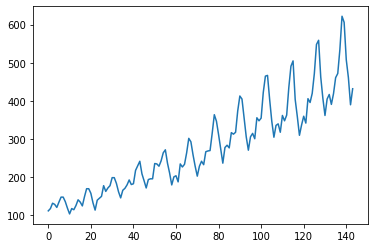

In [4]:
plt.plot(Airlines.Passengers)
plt.show()

In [5]:
# Dickey Fuller test
# Null Hypothesis: time series is not stationary
# if p > 5%, null hypothesis is correct i.e. time series is not stationary
# if p < 5%, null hypothesis is wrong i.e. time series is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(Airlines.Passengers)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


In [7]:
# moving average
count = Airlines.shape[0]
order = 1
ma = list()
for i in np.arange(0,count-order):
    total = 0
    for j in np.arange(i,i+order):
        total = total + Airlines.Passengers[j]
    average = total / order
    ma.append(average)
print(len(ma))

143


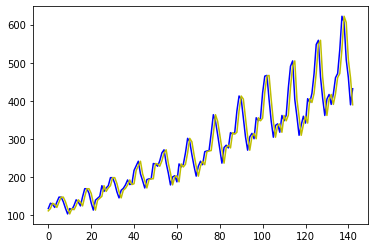

In [16]:
# plot actual and moving average
Actuals = list(Airlines.Passengers[order:144]) 
plt.plot(Actuals, c='b')
plt.plot(ma,c='y')
plt.show()

In [31]:
# calcualted RMSE
print(math.sqrt(mean_squared_error(Actuals, ma)))
print(np.corrcoef(Actuals, ma)**2)

33.710408012832005
[[1.         0.92197376]
 [0.92197376 1.        ]]


In [17]:
# weighted moving average
count = Airlines.shape[0]
order = 3
weights = [0.2,0.3,0.5]
wma = list()
for i in np.arange(0,count-order):
    weightavg = 0
    k = 0
    for j in np.arange(i,i+order):
        weightavg = weightavg + ( Airlines.Passengers[j] * weights[k] )
        k = k + 1
    wma.append(weightavg)
print(len(wma))

141


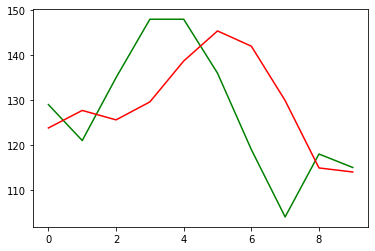

In [18]:
# plot actual and wieghted moving average
Actuals = list(Airlines.Passengers[order:144]) 
plt.plot(Actuals[0:10], c='g')
plt.plot(wma[0:10],c='r')
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
import math
print(math.sqrt(mean_squared_error(Actuals, wma)))
print(np.corrcoef(Actuals, wma)**2)

43.14011149566209
[[1.         0.87080253]
 [0.87080253 1.        ]]


In [20]:
# auto regression
from statsmodels.tsa.ar_model import AR, ARResults
#from statsmodels.tsa.ar_model.AR import select_order
ARmodelO = AR(Airlines.Passengers,dates=Airlines.Month)
order = 12
ARmodel = ARmodelO.fit(maxlag = order,trend = 'c',ic = None, disp=True)
#ARmodel = ARmodelO.fit(ic = 'aic', disp=True)  # identifies optimum order
#ARmodel = ARmodelO.select_order(maxlag = 15, ic = 'aic',trend='nc')  # identifies optimum order
print(type(ARmodel))
#results = ARResults(ARmodel)
#print(ARmodel.summary())

<class 'statsmodels.tsa.ar_model.ARResultsWrapper'>


C:\Users\sohaa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [21]:
# predict for auto regression
ARpredict = ARmodel.predict(start=order, end=count-1)
print(type(ARpredict))
print(ARpredict[0:5])
#print(ARpredict[140:160])

<class 'pandas.core.series.Series'>
1950-01-01    133.054619
1950-02-01    131.079758
1950-03-01    151.199901
1950-04-01    144.699668
1950-05-01    143.436938
Freq: MS, dtype: float64


In [24]:
Airlines.head(15)

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
5,1949-06,135.0
6,1949-07,148.0
7,1949-08,148.0
8,1949-09,136.0
9,1949-10,119.0


In [25]:
ARpredict2 = list(ARpredict)
print(len(ARpredict2))
print(ARpredict2[0:5])

132
[133.05461904776627, 131.07975805581844, 151.19990096202753, 144.69966799032863, 143.43693763649685]


132


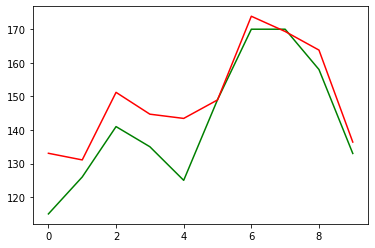

In [26]:
# plot actual and predicted
Actuals = list(Airlines.Passengers[order:144])
print(len(Actuals))
plt.plot(Actuals[0:10], c='g')
plt.plot(ARpredict2[0:10],c='r')
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
import math
print(math.sqrt(mean_squared_error(Actuals, ARpredict2)))
print(np.corrcoef(Actuals, ARpredict2)**2)

13.510646174724856
[[1.         0.98620774]
 [0.98620774 1.        ]]


In [28]:
# ARMA mode
from statsmodels.tsa.arima_model import ARMA
ARorder = 3
MAorder = 3
model = ARMA(Airlines.Passengers, order=(ARorder,MAorder),dates=Airlines.Month)
ARMAmodel = model.fit(disp=False,maxiter=100000)

C:\Users\sohaa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sohaa\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
# predict for ARMA
ARMApredict = ARMAmodel.predict(start=4, end=144)
print(len(ARMApredict))
print(ARMApredict[0:5])
#print(ARIMApredict[139:142])

141
1949-05-01    125.246879
1949-06-01    116.097214
1949-07-01    137.368619
1949-08-01    146.641901
1949-09-01    141.352326
Freq: MS, dtype: float64


In [30]:
# plot actual and predicted
Actuals = list(Airlines.Passengers[3:144])
print(len(Actuals))
ARMApredict2 = list(ARMApredict)
print(len(ARMApredict2))
print(ARMApredict2[0:5])

141
141
[125.24687853951042, 116.09721378231569, 137.36861851545032, 146.64190091581983, 141.3523264048355]


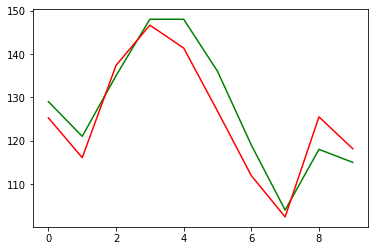

In [31]:
plt.plot(Actuals[0:10], c='g')
plt.plot(ARMApredict2[0:10],c='r')
plt.show()

In [32]:
print(math.sqrt(mean_squared_error(Actuals, ARMApredict2)))
print(np.corrcoef(Actuals, ARMApredict2)**2)

21.6486255738031
[[1.         0.96766606]
 [0.96766606 1.        ]]


In [40]:
# ARIMA mode
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Airlines.Passengers, order=(3,1,3),dates=Airlines.Month)
ARIMAmodel = model.fit(disp=False,maxiter=1000000)

C:\Users\sohaa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sohaa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [41]:
# predict for ARIMA
ARIMApredict = ARIMAmodel.predict(start=3, end=143,typ='levels')
print(type(ARIMApredict))
print(len(ARIMApredict))
print(ARIMApredict[0:5])
print(ARIMApredict[139:141])

<class 'pandas.core.series.Series'>
141
1949-04-01    138.152369
1949-05-01    127.391815
1949-06-01    120.741610
1949-07-01    139.426960
1949-08-01    149.381672
Freq: MS, dtype: float64
1960-11-01    431.667589
1960-12-01    365.452336
Freq: MS, dtype: float64


In [37]:
Airlines.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [42]:
ARIMApredict2 = list(ARIMApredict)
print(len(ARIMApredict2))
print(ARIMApredict2[0:5])

141
[138.15236934020913, 127.39181469246701, 120.74160951511908, 139.42695970121014, 149.38167233792072]


In [46]:
# get the predicted values into original scale
Actuals = list(Airlines.Passengers[3:144])
print(len(Actuals))
from operator import add
ARIMApredict3 = list( map(add, Actuals, ARIMApredict2) ) 
#print(len(ARIMApredict3))
#print(ARIMApredict3[0:5])
#print(ARIMApredict3[139:141])

141


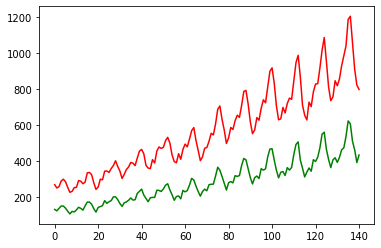

In [47]:
# plot actual and predicted
plt.plot(Actuals, c='g')
plt.plot(ARIMApredict3,c='r')
plt.show()

In [49]:
print(math.sqrt(mean_squared_error(Actuals, ARIMApredict3)))
print(np.corrcoef(Actuals, ARIMApredict3)**2)

305.8702160998088
[[1.         0.98977756]
 [0.98977756 1.        ]]


In [50]:
# Simple exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(Airlines.Passengers)
SE = model.fit(smoothing_level = 0.95)

In [51]:
# predict for SE
SEpredict = list(SE.predict(start=1, end=143))
print(len(SEpredict))
print(type(SEpredict))
print(SEpredict[0:5])
print(SEpredict[138:144])

143
<class 'list'>
[112.01672617412014, 117.700836308706, 131.2850418154353, 129.11425209077177, 121.40571260453858]
[617.4908541452892, 606.5745427072644, 512.9287271353633, 463.59643635676815, 393.67982181783844]


143


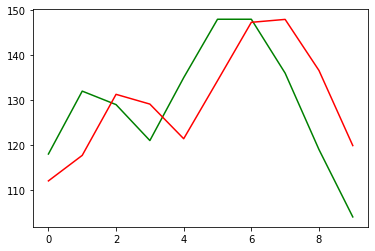

In [52]:
# plot actual and predicted
import matplotlib.pyplot as plt
Actuals = list(Airlines.Passengers[1:144])
print(len(Actuals))
plt.plot(Actuals[0:10], c='g')
plt.plot(SEpredict[0:10],c='r')
plt.show()

In [53]:
print(math.sqrt(mean_squared_error(Actuals, SEpredict)))
print(np.corrcoef(Actuals, SEpredict)**2)

34.254471279469655
[[1.         0.91936124]
 [0.91936124 1.        ]]


In [54]:
# Holtwinter exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(Airlines.Passengers,trend='additive',
                             seasonal='additive',
                            seasonal_periods=12)
HES = model.fit(smoothing_level=0.4,smoothing_slope=0.4,smoothing_seasonal=0.4)

In [55]:
# predict for HES
HESpredict = list(HES.predict(start=12, end=143))
print(len(HESpredict))
print(type(HESpredict))
print(HESpredict[0:5])
print(HESpredict[126:130])

132
<class 'list'>
[142.36291821729918, 131.00229564217375, 135.9250500178357, 123.570124816716, 111.08486759639747]
[582.4898672233458, 595.0356302688202, 503.44005464830536, 454.6630542134622]


132


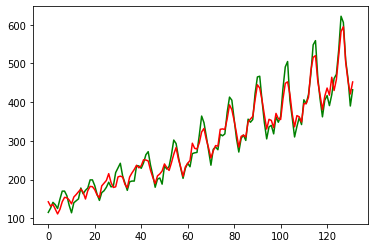

In [56]:
# plot actual and predicted
Actuals = list(Airlines.Passengers[12:144])
print(len(Actuals))
plt.plot(Actuals, c='g')
plt.plot(HESpredict,c='r')
plt.show()

In [57]:
print(math.sqrt(mean_squared_error(Actuals, HESpredict)))
print(np.corrcoef(Actuals, HESpredict)**2)

18.485974193843717
[[1.         0.97465521]
 [0.97465521 1.        ]]


In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(Airlines.Passengers,model='additive',
                       freq=12)

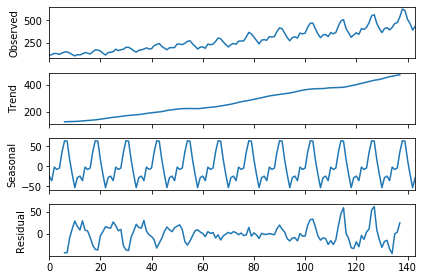

In [59]:
sd.plot()
plt.show()